In [1]:
"""Overall agent."""
import json
from typing import TypedDict, Literal
from langgraph.graph import END, StateGraph
from langchain_core.messages import HumanMessage
from eaia.main.triage import (
    triage_input,
)
from eaia.main.draft_response import draft_response
from eaia.main.find_meeting_time import find_meeting_time
from eaia.main.rewrite import rewrite
from eaia.main.config import get_config
from langchain_core.messages import ToolMessage
from eaia.main.human_inbox import (
    send_message,
    send_email_draft,
    notify,
    send_cal_invite,
)
from eaia.gmail import (
    send_email,
    mark_as_read,
    send_calendar_invite,
)
from eaia.schemas import (
    State,
)


C:\Users\ddawk\OneDrive\Desktop\codeCamp\executive-ai-assistant\eaia\main\find_meeting_time.py:9: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from eaia.gmail import get_events_for_days


In [2]:


def route_after_triage(
    state: State,
) -> Literal["draft_response", "mark_as_read_node", "notify"]:
    if state["triage"].response == "text":
        return "draft_response"
    elif state["triage"].response == "no":
        return "mark_as_read_node"
    elif state["triage"].response == "notify":
        return "notify"
    elif state["triage"].response == "question":
        return "draft_response"
    else:
        raise ValueError


def take_action(
    state: State,
) -> Literal[
    "send_message",
    # "rewrite",
    "mark_as_read_node",
    # "find_meeting_time",
    # "send_cal_invite",
    "bad_tool_name",
]:
    prediction = state["messages"][-1]
    if len(prediction.tool_calls) != 1:
        raise ValueError
    tool_call = prediction.tool_calls[0]
    if tool_call["name"] == "Question":
        return "send_message"
    elif tool_call["name"] == "ResponseTextDraft":
        return "mark_as_read_node"
    # elif tool_call["name"] == "Ignore":
    #     return "mark_as_read_node"
    # elif tool_call["name"] == "MeetingAssistant":
    #     return "find_meeting_time"
    # elif tool_call["name"] == "SendCalendarInvite":
    #     return "send_cal_invite"
    else:
        return "bad_tool_name"


def bad_tool_name(state: State):
    tool_call = state["messages"][-1].tool_calls[0]
    message = f"Could not find tool with name `{tool_call['name']}`. Make sure you are calling one of the allowed tools!"
    last_message = state["messages"][-1]
    last_message.tool_calls[0]["name"] = last_message.tool_calls[0]["name"].replace(
        ":", ""
    )
    return {
        "messages": [
            last_message,
            ToolMessage(content=message, tool_call_id=tool_call["id"]),
        ]
    }


def enter_after_human(
    state,
) -> Literal[
    "mark_as_read_node", "draft_response"
]:
    messages = state.get("messages") or []
    if len(messages) == 0:
        if state["triage"].response == "notify":
            return "mark_as_read_node"
        raise ValueError
    else:
        if isinstance(messages[-1], (ToolMessage, HumanMessage)):
            return "draft_response"
        else:
            execute = messages[-1].tool_calls[0]
            if execute["name"] == "ResponseEmailDraft":
                return "send_email_node"
            elif execute["name"] == "SendCalendarInvite":
                return "send_cal_invite_node"
            elif execute["name"] == "Ignore":
                return "mark_as_read_node"
            elif execute["name"] == "Question":
                return "draft_response"
            else:
                raise ValueError


def send_cal_invite_node(state, config):
    tool_call = state["messages"][-1].tool_calls[0]
    _args = tool_call["args"]
    email = get_config(config)["email"]
    try:
        send_calendar_invite(
            _args["emails"],
            _args["title"],
            _args["start_time"],
            _args["end_time"],
            email,
        )
        message = "Sent calendar invite!"
    except Exception as e:
        message = f"Got the following error when sending a calendar invite: {e}"
    return {"messages": [ToolMessage(content=message, tool_call_id=tool_call["id"])]}


def send_email_node(state, config):
    tool_call = state["messages"][-1].tool_calls[0]
    _args = tool_call["args"]
    email = get_config(config)["email"]
    new_receipients = _args["new_recipients"]
    if isinstance(new_receipients, str):
        new_receipients = json.loads(new_receipients)
    send_email(
        state["email"]["id"],
        _args["content"],
        email,
        addn_receipients=new_receipients,
    )


def mark_as_read_node(state):
    # mark_as_read(state["text"]["id"])
    print("Marked as read:", state["text"]["id"])


def human_node(state: State):
    pass


class ConfigSchema(TypedDict):
    db_id: int
    model: str





In [3]:
graph_builder = StateGraph(State, config_schema=ConfigSchema)
graph_builder.add_node(human_node)
graph_builder.add_node(triage_input)
graph_builder.add_node(draft_response)
graph_builder.add_node(send_message)

# graph_builder.add_node(rewrite)
graph_builder.add_node(mark_as_read_node)
# graph_builder.add_node(send_email_draft)
# graph_builder.add_node(send_email_node)

graph_builder.add_node(bad_tool_name)
graph_builder.add_node(notify)

# graph_builder.add_node(send_cal_invite_node)
# graph_builder.add_node(send_cal_invite)

graph_builder.add_conditional_edges("triage_input", route_after_triage)
graph_builder.set_entry_point("triage_input")
graph_builder.add_conditional_edges("draft_response", take_action)
graph_builder.add_edge("send_message", "human_node")

# graph_builder.add_edge("send_cal_invite", "human_node")
# graph_builder.add_node(find_meeting_time)
# graph_builder.add_edge("find_meeting_time", "draft_response")

graph_builder.add_edge("bad_tool_name", "draft_response")

# graph_builder.add_edge("send_cal_invite_node", "draft_response")
# graph_builder.add_edge("send_email_node", "mark_as_read_node")
# graph_builder.add_edge("rewrite", "send_email_draft")
# graph_builder.add_edge("send_email_draft", "human_node")
graph_builder.add_edge("mark_as_read_node", END)

graph_builder.add_edge("notify", "human_node")
graph_builder.add_conditional_edges("human_node", enter_after_human)
graph = graph_builder.compile()

In [5]:

import os
from dotenv import load_dotenv

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = "sk-..."  # <-- Replace with your actual OpenAI API key


# Run the multi-agent graph
# Load environment variables from .env file
load_dotenv()

def pretty_print_messages(chunk):
    print(json.dumps(chunk, indent=2, default=str))

# Run the multi-agent graph
await graph.ainvoke(
    input={
        "text":
            {
                # example of a text message
                "id": "str",
                "thread_id": "str",
                "from_phone_number": "str",
                "text_content": "str",
                "send_time": "str",
                "to_phone_number": "str"
            }
    },
    # config=get_config(config)
    subgraphs=True
)

KeyError: 'email'

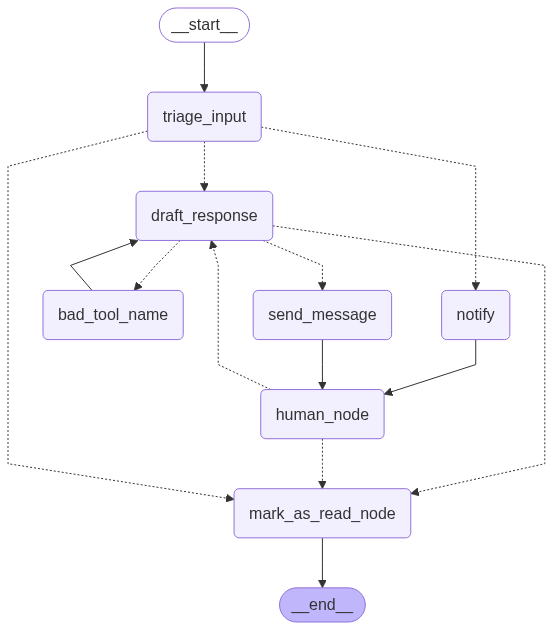

In [ ]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))